In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import  glob
import seaborn as sns
import re
from io import StringIO

sns.set_palette("husl")

tocategory = lambda col: pd.Categorical(col)
underscoretospace = lambda x: x.replace("_", " ") if type(x) is str else x
def q5(x): return x.quantile(.05)
def q95(x): return x.quantile(.95)

In [2]:
dataset = "initial"
dataset = "incremental"

filenames = glob.glob(f"data/{dataset}/*/lsb.*.r*")
params = ["Algorithm", "Max threads", "Graph nodes"];

def remove_space(filename):
    with open(filename) as f:
        return re.sub(" +", ' ', f.read())

files = [StringIO(remove_space(filename)) for filename in filenames]

In [3]:
def get_df(file):
    return (pd
      .read_csv(file, sep=" ", comment="#", skipinitialspace=True, index_col="id")
      .applymap(underscoretospace)
      .dropna("columns", "all")
    )
df = pd.concat(get_df(file) for file in files)
df[["Algorithm", "Graph_name"]] = df[["Algorithm", "Graph_name"]].apply(tocategory)
df.columns = df.columns.map(underscoretospace)
df['Graph'] = df.apply(lambda x: (x['Graph name'], x['Graph nodes']), 1)
df["Throughput"] = 1/df["time"]

In [4]:
df.head(5)

,Algorithm,Graph nodes,Graph name,Max threads,run,time,overhead,Graph,Throughput
id,,,,,,,,,
0,Filter Kruskal,100000,Preferential attachment 50 edges per vertice,1,0,643043.089600,0,"(Preferential attachment 50 edges per vertice,...",0.000002
0,Filter Kruskal,100000,Preferential attachment 50 edges per vertice,1,1,434225.026367,2,"(Preferential attachment 50 edges per vertice,...",0.000002
0,Filter Kruskal,100000,Preferential attachment 50 edges per vertice,2,0,353617.151367,1,"(Preferential attachment 50 edges per vertice,...",0.000003
0,Filter Kruskal,100000,Preferential attachment 50 edges per vertice,2,1,298995.413086,0,"(Preferential attachment 50 edges per vertice,...",0.000003
0,Filter Kruskal,100000,Preferential attachment 50 edges per vertice,4,0,198315.129883,2,"(Preferential attachment 50 edges per vertice,...",0.000005


In [5]:
df.tail(5)

,Algorithm,Graph nodes,Graph name,Max threads,run,time,overhead,Graph,Throughput
id,,,,,,,,,
0,Filter Kruskal,10000,Preferential attachment 1000 edges per vertice,8,1,209504.621582,0,(Preferential attachment 1000 edges per vertic...,0.000005
0,Filter Kruskal,10000,Preferential attachment 1000 edges per vertice,16,0,220336.085938,3,(Preferential attachment 1000 edges per vertic...,0.000005
0,Filter Kruskal,10000,Preferential attachment 1000 edges per vertice,16,1,171889.718018,0,(Preferential attachment 1000 edges per vertic...,0.000006
0,Filter Kruskal,10000,Preferential attachment 1000 edges per vertice,32,0,189337.122070,0,(Preferential attachment 1000 edges per vertic...,0.000005
0,Filter Kruskal,10000,Preferential attachment 1000 edges per vertice,32,1,206666.510986,0,(Preferential attachment 1000 edges per vertic...,0.000005


In [6]:
timequantiles = df.groupby(params).agg([q5, q95])["time"]
df_timequantiles =  timequantiles.loc[map(tuple, df[params].values)]

In [7]:
summary = (df[params + ["time"]]
    [(df.time >= df_timequantiles["q5"].values) & (df.time <= df_timequantiles["q95"].values)]
    .groupby(params).agg(["median", "mean", "min", "max", "std"])
)

In [8]:
summary

time                 \
                                               median           mean   
Algorithm      Max threads Graph nodes                                 
Filter Kruskal 1           10000        895865.996216  862896.306261   
                           100000       426471.361816  479559.044990   
               2           10000        494184.350586  531925.004083   
                           100000       283188.045655  264902.015082   
               4           10000        337999.096924  334950.608209   
                           100000       165447.876098  162270.761366   
               8           10000        249649.483399  250536.660373   
                           100000       138949.558960  145796.649577   
               16          10000        169158.666871  162503.093899   
                           100000       139280.355835  139349.211670   
               32          10000        198190.997558  227482.714884   
                           100000       184198.028076  194639.220934   

                                                                     \
                                                  min           max   
Algorithm      Max threads Graph nodes                                
Filter Kruskal 1           10000        395519.983643  1.259299e+06   
                           100000       304060.472412  8.865506e+05   
               2           10000        315148.615234  8.548618e+05   
                           100000       179389.567383  3.536172e+05   
               4           10000        188785.797363  5.568932e+05   
                           100000       126773.605469  1.983151e+05   
               8           10000        115880.116211  3.486453e+05   
                           100000        94711.266602  2.260337e+05   
               16          10000         98180.767822  2.212042e+05   
                           100000       109501.988525  2.219766e+05   
               32          10000        116767.099854  4.136297e+05   
                           100000       153215.186768  3.044575e+05   

                                                       
                                                  std  
Algorithm      Max threads Graph nodes                 
Filter Kruskal 1           10000        319145.813489  
                           100000       162239.733243  
               2           10000        199566.024054  
                           100000        64799.146109  
               4           10000        115167.451421  
                           100000        28659.910288  
               8           10000         63195.762700  
                           100000        43173.960895  
               16          10000         42041.687103  
                           100000        25241.199398  
               32          10000         89459.404448  
                           100000        38381.377868

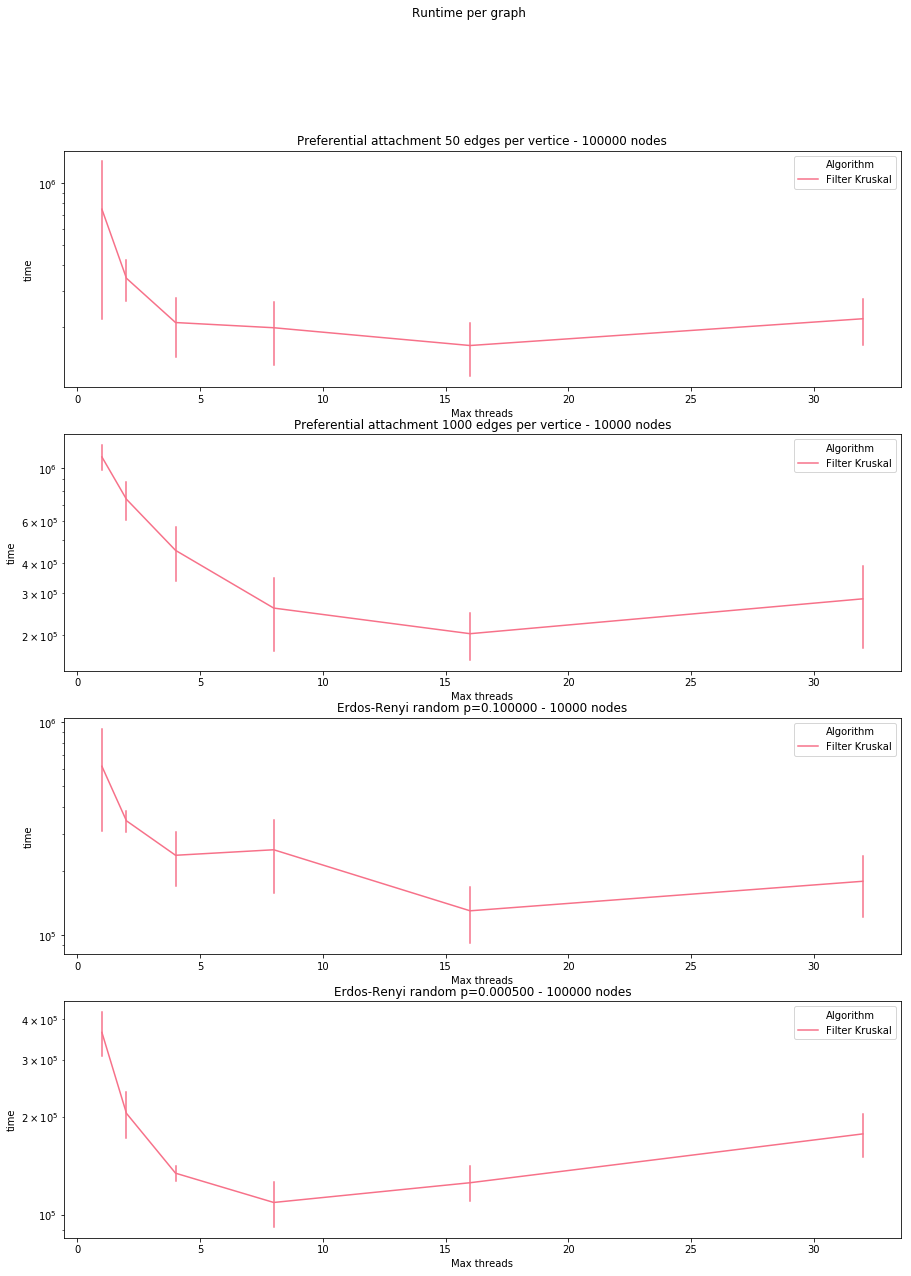

In [9]:
fig, ax = plt.subplots(nrows=len(df.Graph.unique()),figsize=(15,5*len(df.Graph.unique())))
for i, e in enumerate(df.Graph.unique()):
    sns.lineplot(
        ax=ax[i], 
        data=df[df.Graph == e], 
        x="Max threads", 
        y="time", 
        hue="Algorithm",
        markers=True,
        ci="sd",
        err_style="bars",
    ).set(yscale="log")
    ax[i].set_title(f"{e[0]} - {e[1]} nodes")
    #ax[i].set_ylim(1,)
plt.suptitle("Runtime per graph")
fig.savefig(f"figures/{dataset}/Graph_runtime.png", dpi=450)
plt.show()

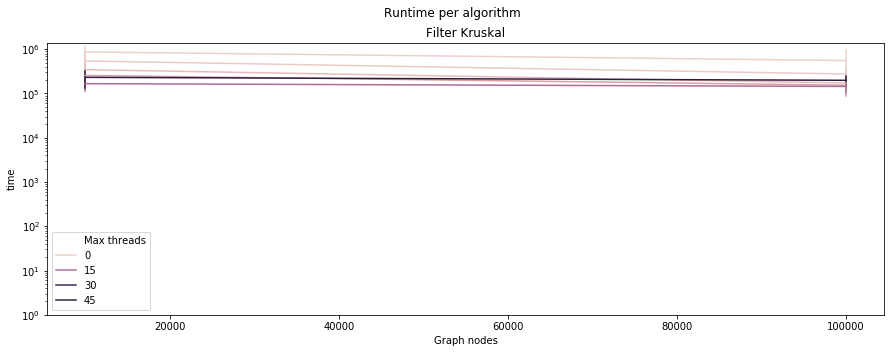

In [13]:
fig, ax = plt.subplots(nrows=len(df["Algorithm"].unique()),figsize=(15,5*len(df["Algorithm"].unique())))
for i, e in enumerate(df["Algorithm"].unique()):
    axi = ax[i] if len(df["Algorithm"].unique()) > 1 else ax
    sns.lineplot(
        ax=axi,
        data=df[df["Algorithm"].values == e], 
        x="Graph nodes", 
        y="time", 
        hue="Max threads",
        markers=True,
        ci="sd",
        err_style="bars",
    ).set(yscale="log")
    axi.set_title(f"{e}")
    axi.set_ylim(1,)
plt.suptitle("Runtime per algorithm")
fig.savefig(f"figures/{dataset}/AlgoRuntime.png", dpi=450)
plt.show()

In [ ]:
g_idx = ["Graph nodes", "Graph name"]
graphs = df[g_idx].drop_duplicates().values

/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


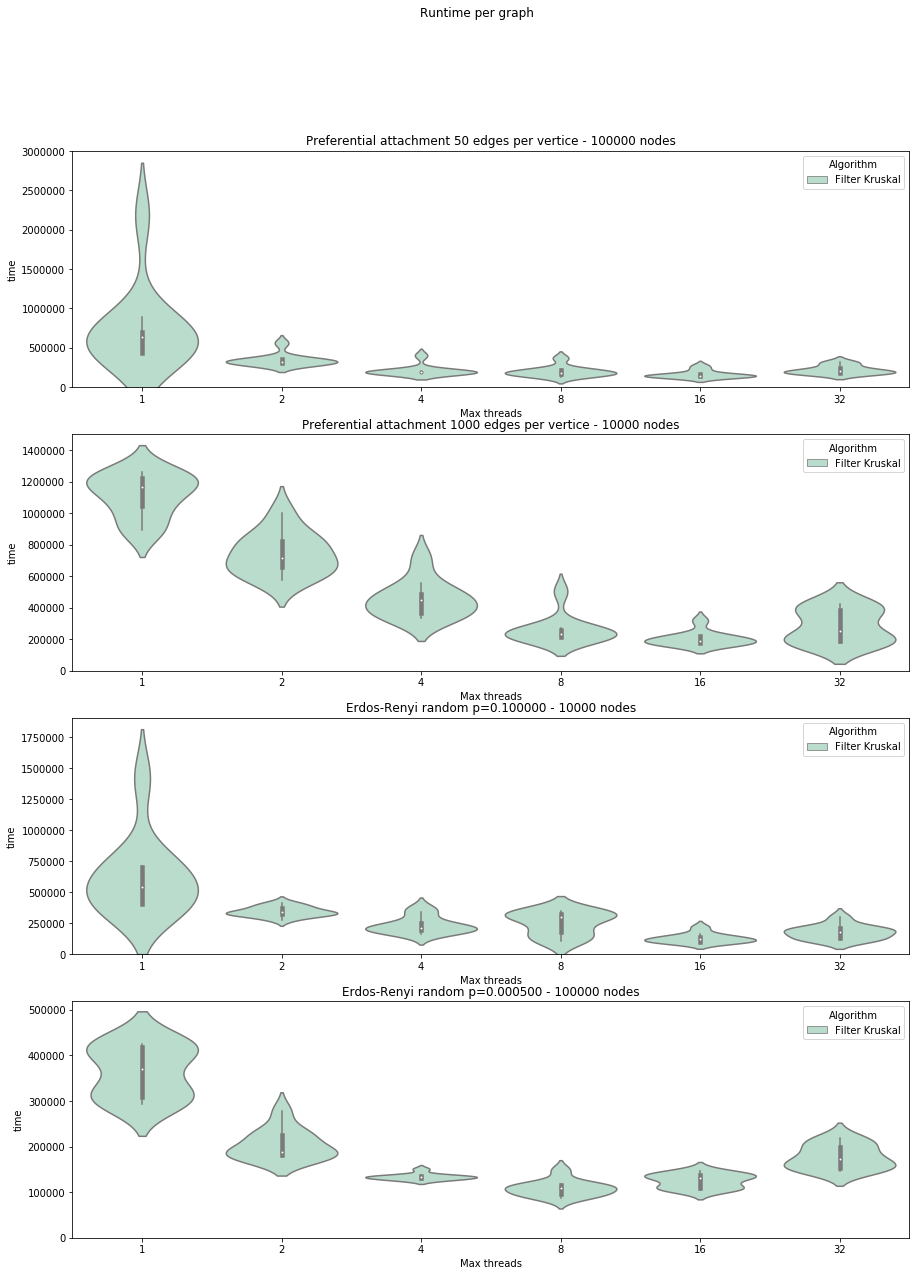

In [14]:
fig, ax = plt.subplots(nrows=len(df.Graph.unique()),figsize=(15,5*len(df.Graph.unique())))
for i, e in enumerate(df.Graph.unique()):
    sns.violinplot(
        x="Max threads", y="time", hue="Algorithm", 
        data=df[df.Graph == e], 
        palette="Pastel2", ax=ax[i]
    )
    ax[i].set_title(f"{e[0]} - {e[1]} nodes")
    ax[i].set_ylim(0,)
plt.suptitle("Runtime per graph")
fig.savefig(f"figures/{dataset}/ViolinRuntime.png", dpi=450)
plt.show()

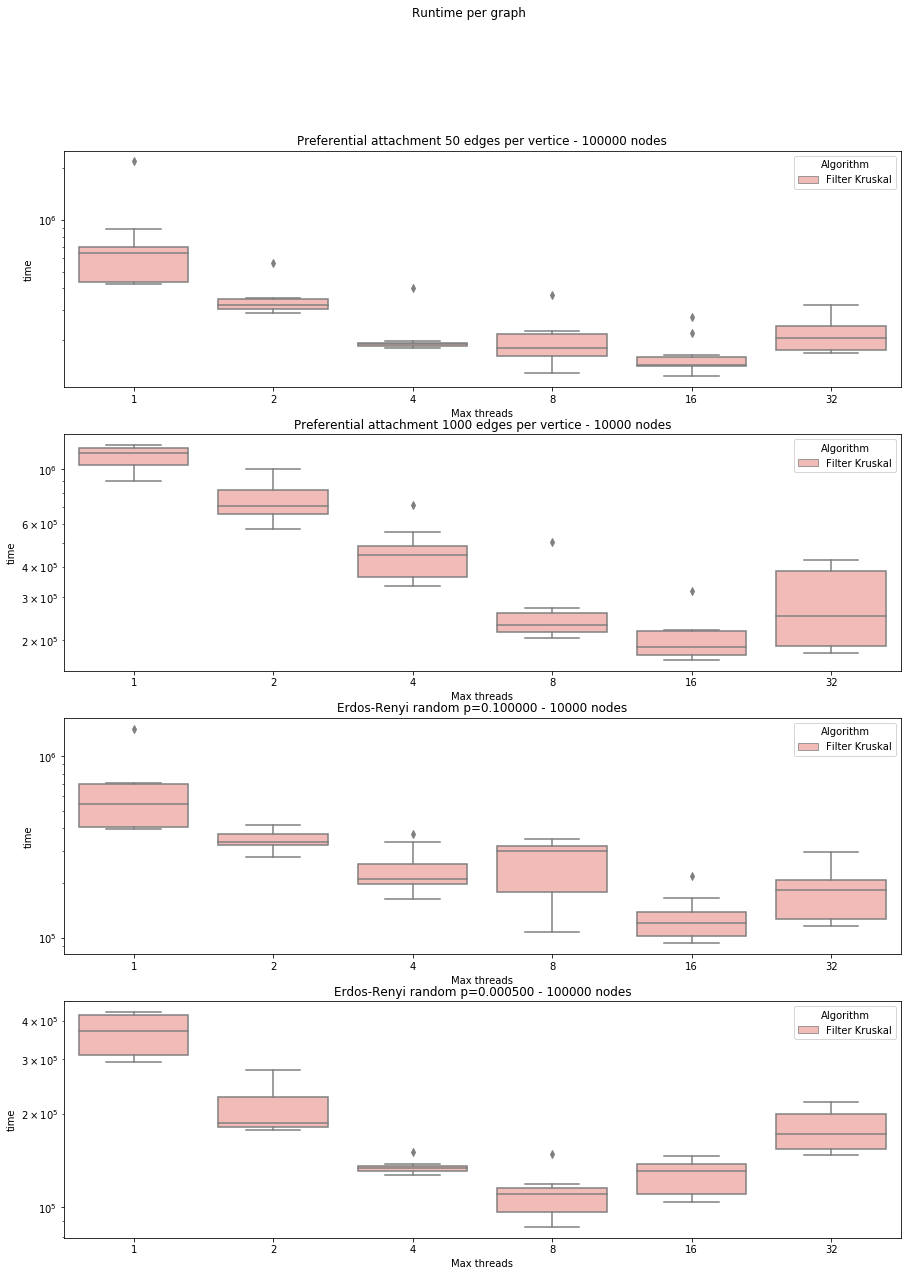

In [17]:
fig, ax = plt.subplots(nrows=len(df.Graph.unique()),figsize=(15,5*len(df.Graph.unique())))
for i, e in enumerate(df.Graph.unique()):
    sns.boxplot(
        x="Max threads", y="time", hue="Algorithm", 
        data=df[df.Graph == e], 
        palette="Pastel1", ax=ax[i]
    ).set(yscale="log")
    ax[i].set_title(f"{e[0]} - {e[1]} nodes")
plt.suptitle("Runtime per graph")
fig.savefig(f"figures/{dataset}/BoxRuntime.png", dpi=450)
plt.show()

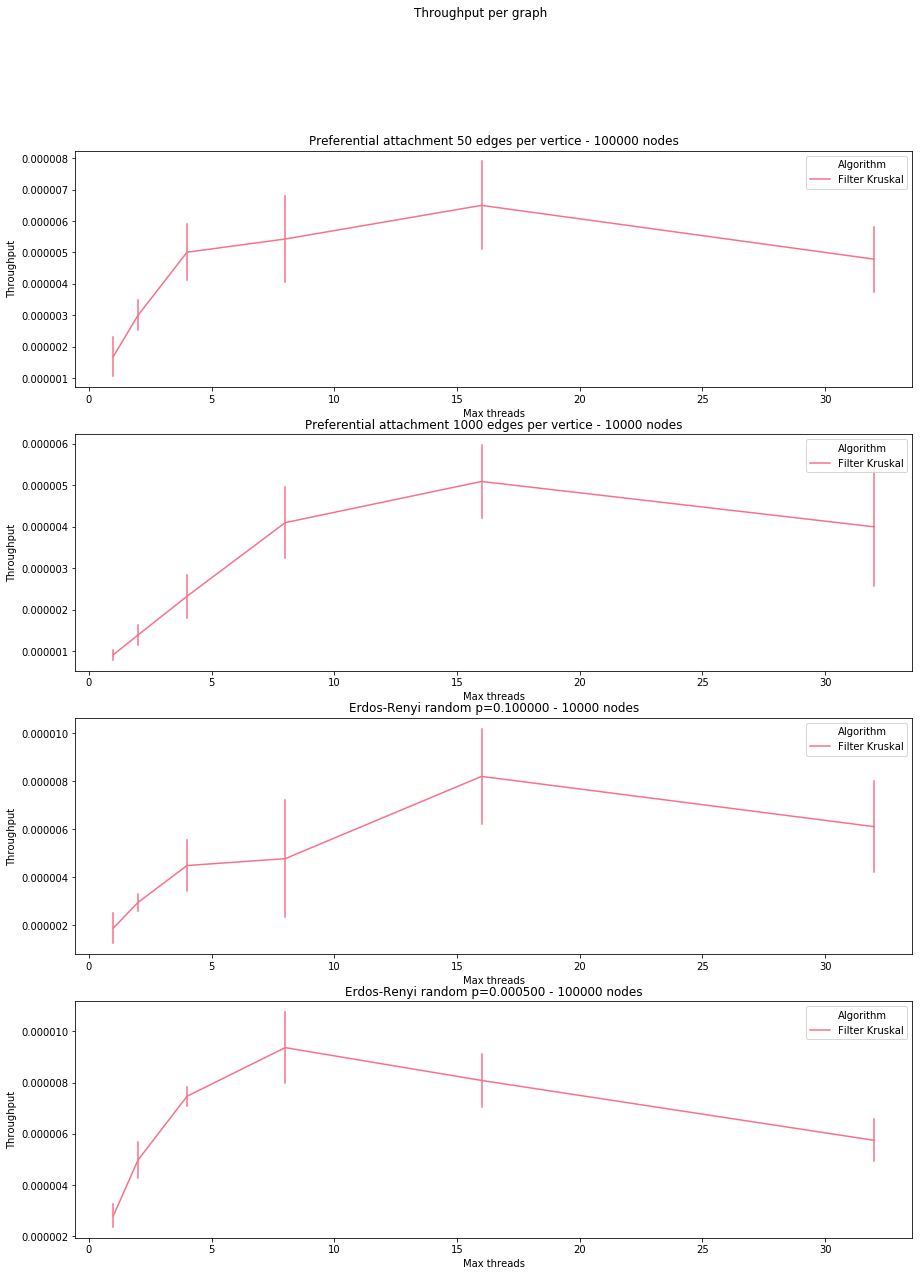

In [16]:
fig, ax = plt.subplots(nrows=len(df.Graph.unique()),figsize=(15,5*len(df.Graph.unique())))
for i, e in enumerate(df.Graph.unique()):
    sns.lineplot(
        ax=ax[i], 
        data=df[df.Graph == e], 
        x="Max threads", 
        y="Throughput", 
        hue="Algorithm",
        markers=True,
        ci="sd",
        err_style="bars",
    )#.set(yscale="log")
    ax[i].set_title(f"{e[0]} - {e[1]} nodes")
    #ax[i].set_ylim(1,)
plt.suptitle("Throughput per graph")
fig.savefig(f"figures/{dataset}/Throughput.png", dpi=450)
plt.show()

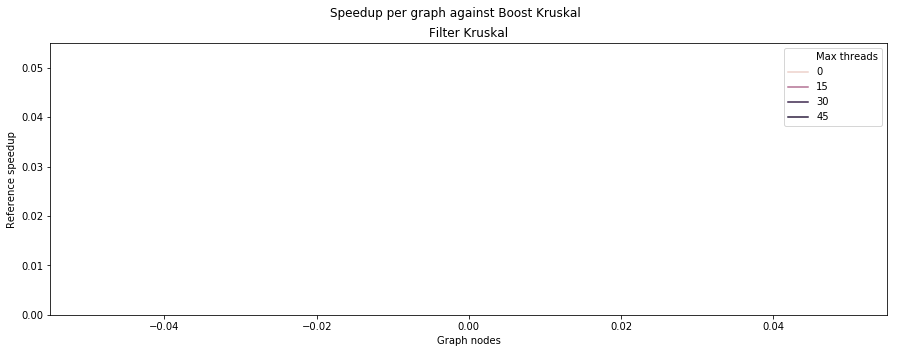

In [18]:
reference_algorithm = "Boost Kruskal"

reference_times = df[(df.Algorithm == reference_algorithm) & (df['Max threads'] == 1)][["Graph", "time"]].groupby('Graph').median()['time']

df['Reference speedup'] = df.apply(lambda x: reference_times[x.Graph] / x.time if x.Graph in reference_times.index else None , 1)

fig, ax = plt.subplots(nrows=len(df.Algorithm.unique()),figsize=(15,5*len(df.Algorithm.unique())))
for i, e in enumerate(df["Algorithm"].unique()):
    axi = ax[i] if len(df["Algorithm"].unique()) > 1 else ax
    sns.lineplot(
        ax=axi, 
        data=df[df.Algorithm == e], 
        x="Graph nodes", 
        y="Reference speedup", 
        hue="Max threads",
        ci="sd",
        err_style="bars",
    )#.set(yscale="log")
    axi.set_title(f"{e}")
    axi.set_ylim(0,)
plt.suptitle(f"Speedup per graph against {reference_algorithm}")
r_name = reference_algorithm.replace(' ', '_')
fig.savefig(f"figures/{dataset}/Speedup_against_{r_name}.png", dpi=450)
plt.show()

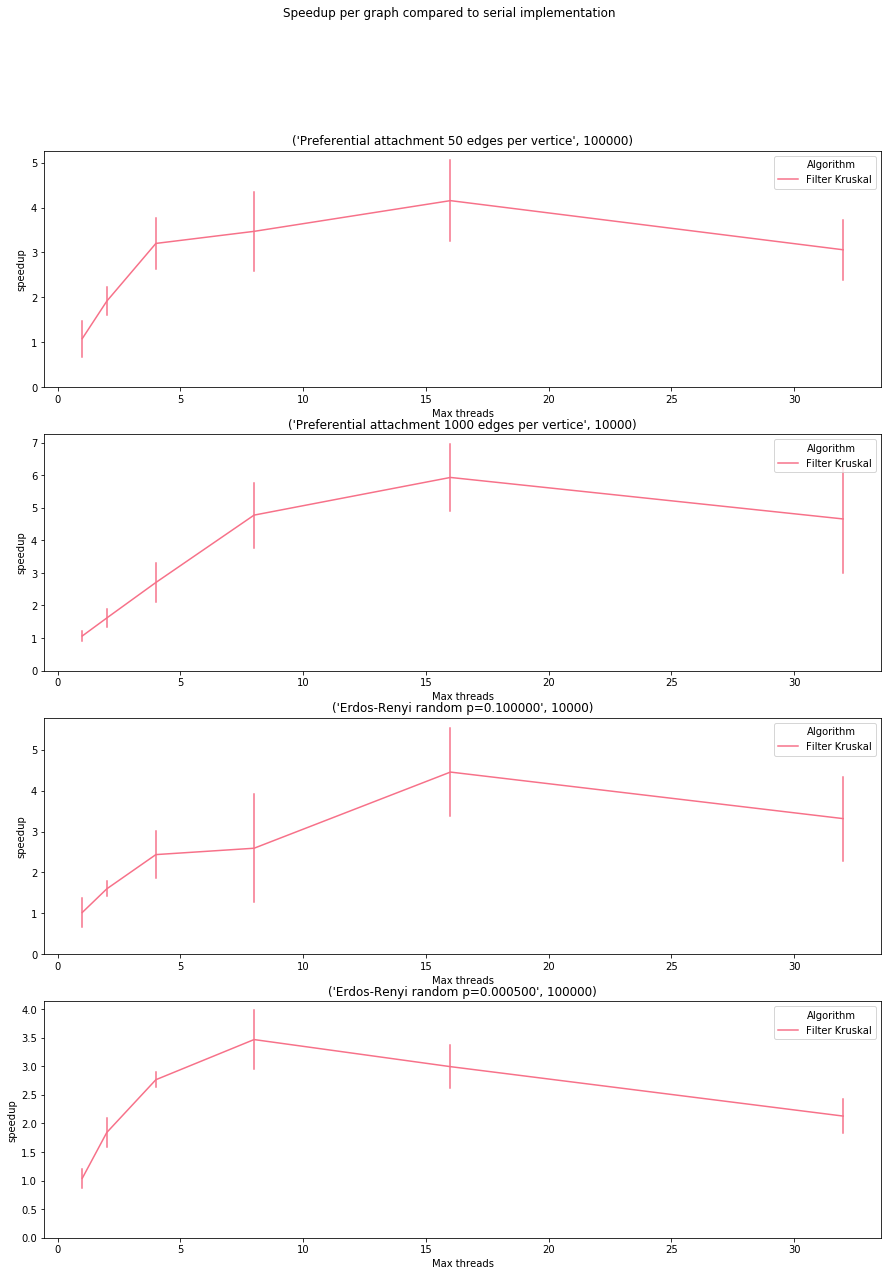

In [19]:
df['speedup'] = df.apply(lambda x: df[(df.Algorithm == x.Algorithm) & (df.Graph == x.Graph) & (df['Max threads'] == 1)].time.median() / x.time, 1)

fig, ax = plt.subplots(nrows=len(df.Graph.unique()),figsize=(15,5*len(df.Graph.unique())))
for i, e in enumerate(df.Graph.unique()):
    sns.lineplot(
        ax=ax[i], 
        data=df[df.Graph == e], 
        x="Max threads", 
        y="speedup", 
        hue="Algorithm",
        ci="sd",
        err_style="bars",
    )#.set(yscale="log")
    ax[i].set_title(f"{e}")
    ax[i].set_ylim(0,)
plt.suptitle(f"Speedup per graph compared to serial implementation")
fig.savefig(f"figures/{dataset}/Speedup.png", dpi=450)
plt.show()